# Physical coupling of hydrologic processes

This module tests the physical coupling of hydrologic processes

For overland flow, we call the overlandFlow module by Bates et al. 2012

For infiltration, we use our CREST model to compute ground water recharge

For groundwater, we use dupuit percolator module

In [1]:
# initialize all necessary modules
from landlab import Component, LinkStatus
from landlab.components.hydrologic_model import CRESTPHYS
from landlab.plot.imshow import imshow_grid
from landlab.plot.colors import water_colormap
from landlab import RasterModelGrid
from landlab.io.esri_ascii import read_esri_ascii
from matplotlib.pyplot import figure
import numpy as np
from time import time
%matplotlib inline

import xarray as xr
import rioxarray
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
basin_shp= basin_shp.set_crs('EPSG:4326')
basin_shp= basin_shp.to_crs('EPSG:32215')

In [3]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/CRM_Houston_NAm83/DEM_100m.tif')
# dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/demHouston033s_NAm83.tif/demHouston033s_NAm83.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')

In [4]:
basin_dem= dem_region.rio.clip(basin_shp.geometry,
                               basin_shp.crs).squeeze().sortby('y', ascending=True)

In [5]:
basin= RasterModelGrid(shape= basin_dem.squeeze().shape,
                       xy_spacing=np.diff(basin_dem.x.values)[0],
                       xy_of_lower_left= [basin_dem.x.values[0], basin_dem.y.values[0]]
                      )
basin.axis_units = ('m', 'm')

In [6]:
z= basin.add_field('topographic__elevation', basin_dem.values.astype(np.float32),
                   at="node", clobber=True, dtype=float)
z= basin.add_field('surface_water__elevation', basin_dem.values.astype(np.float32)+0.0001,
                   at="node", clobber=True, dtype=float)
z= basin.add_field('aquifer_base__elevation', basin_dem.values.astype(np.float32)-30,
                   at="node", clobber=True, dtype=float)
z= basin.add_field('ground_water__elevation', basin_dem.values.astype(np.float32)-30,
                   at="node", clobber=True, dtype=float)

In [7]:
def load_param(path, lons=basin_dem.x.values, lats=basin_dem.y.values):
    param= rioxarray.open_rasterio(path)
    param= param.rio.write_crs('EPSG:4326').rio.reproject('EPSG:32215')
    param= param.sel(x= lons, y=lats, method='nearest')
    return param.values
    

In [8]:
basin.status_at_node[basin.nodes_at_bottom_edge] = basin.BC_NODE_IS_FIXED_VALUE
basin.status_at_node[np.isclose(z, basin_dem._FillValue)] = basin.BC_NODE_IS_CLOSED
basin.set_watershed_boundary_condition_outlet_id(8954, 'topographic__elevation')

In [9]:
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/params/params_b_usa.tif')
_= basin.add_field('B__param', param, at="node", dtype=np.float32,clobber=True)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/params/params_wm_usa.tif')
_= basin.add_field('WM__param', param, at="node", units='mm',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/params/params_ksat_usa.tif')
_= basin.add_field('Ksat_soil__param', param, at="node", units='mm/hr',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/params/params_im_usa.tif')
_= basin.add_field('IM__param', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/sm.20170826.120000.tif')
_= basin.add_zeros('soil_moisture__content', at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/friction/manningn.tif')
_= basin.add_field('manning_n__param', param, at="node",clobber=True, dtype=np.float32)
_= basin.add_ones('KE__param', at="node",clobber=True, dtype=np.float32)
_= basin.add_ones('Ksat_groundwater__param', at="link",clobber=True, dtype=np.float32)
basin.at_link['Ksat_groundwater__param']*=0.003


In [10]:
_= basin.add_ones('Ksat_groundwater__param', at="link",clobber=True, dtype=np.float32)
basin.at_link['Ksat_groundwater__param']*=0.003

In [11]:
def map_to_grid(fname, lons, lats, proj):
    field= rioxarray.open_rasterio(fname)
    field= field.rio.write_crs('EPSG:4326').rio.reproject(proj)
    field= field.sel(x=lons, y= lats, method='nearest')

    return field.values

In [12]:
model= CRESTPHYS(basin, proj='EPSG:32215')
lons= model.lons; lats=model.lats
for t in range(1,3600*24*7, 3600):
    datetime= pd.to_datetime('20170826000000') + pd.Timedelta(seconds=t)
    print(datetime)    
    fname= datetime.strftime('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/mrms201708/PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif')
    model.precip= map_to_grid(fname, lons, lats, 'EPSG:32215')/3600.
    fname= datetime.strftime('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/evap/cov_et%y%m%d.asc.tif')
    model.evap= map_to_grid(fname, lons, lats, 'EPSG:32215')/3600./24.
    model.run_one_step(dt= 3600)
#     print()

2017-08-26 00:00:01
2017-08-26 01:00:01
2017-08-26 02:00:01
2017-08-26 03:00:01
2017-08-26 04:00:01
2017-08-26 05:00:01
2017-08-26 06:00:01
2017-08-26 07:00:01
2017-08-26 08:00:01
2017-08-26 09:00:01
2017-08-26 10:00:01
2017-08-26 11:00:01
2017-08-26 12:00:01
2017-08-26 13:00:01
2017-08-26 14:00:01
2017-08-26 15:00:01
2017-08-26 16:00:01
2017-08-26 17:00:01
2017-08-26 18:00:01
2017-08-26 19:00:01
2017-08-26 20:00:01
2017-08-26 21:00:01
2017-08-26 22:00:01
2017-08-26 23:00:01
2017-08-27 00:00:01
2017-08-27 01:00:01
2017-08-27 02:00:01
2017-08-27 03:00:01
2017-08-27 04:00:01
2017-08-27 05:00:01
2017-08-27 06:00:01
2017-08-27 07:00:01
2017-08-27 08:00:01
2017-08-27 09:00:01
2017-08-27 10:00:01
2017-08-27 11:00:01
2017-08-27 12:00:01
2017-08-27 13:00:01
2017-08-27 14:00:01
2017-08-27 15:00:01
2017-08-27 16:00:01
2017-08-27 17:00:01
2017-08-27 18:00:01
2017-08-27 19:00:01
2017-08-27 20:00:01
2017-08-27 21:00:01
2017-08-27 22:00:01
2017-08-27 23:00:01
2017-08-28 00:00:01
2017-08-28 01:00:01


KeyboardInterrupt: 

In [ ]:
imshow_grid(basin, model.precip)

In [ ]:
(basin['node']['surface_water__elevation']-basin['node']['topographic__elevation'])[basin.core_nodes]

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


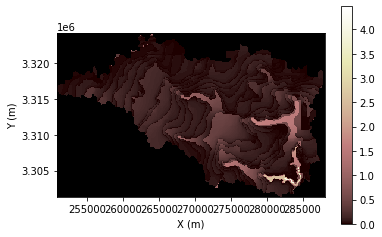

In [13]:
imshow_grid(basin, basin['node']['surface_water__elevation']-basin['node']['topographic__elevation'])

In [ ]:
basin['node']['surface_water__elevation'][basin._core_nodes]

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("seismic"))
  cmap.set_bad(color=color_for_closed)


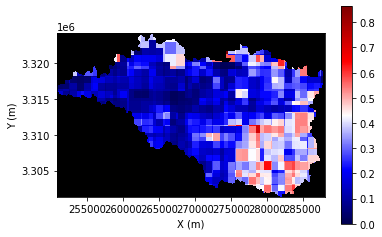

In [14]:
imshow_grid(basin, basin['node']['ground_water__elevation']-\
            basin['node']['aquifer_base__elevation'],
            cmap='seismic')

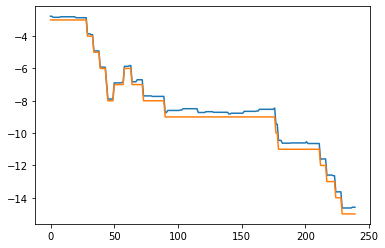

In [18]:
plt.plot((basin['node']['ground_water__elevation']).reshape(basin.shape)[100,160:400])
plt.plot((basin['node']['aquifer_base__elevation']).reshape(basin.shape)[100,160:400])

In [19]:
from landlab.components import ChannelProfiler

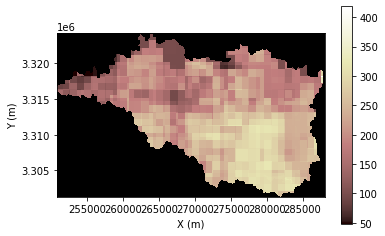

In [15]:
imshow_grid(basin, 'soil_moisture__content')

In [ ]:
basin['node']['surface_water__elevation'][basin.core_nodes]

In [ ]:
imshow_grid(basin, 'B__param')

In [ ]:
basin.__dict__

# Test overland flow generation process

In [ ]:
boundaries = {'top': 'closed','bottom': 'open','right':'closed','left':'closed'}
basin= RasterModelGrid((100,160), xy_spacing=10.0, xy_axis_units='-',bc= boundaries)

In [ ]:
def construct_topo(x,y):
    #z(500,800)=0
    z= abs(800-x)*0.05+(1000-y)*0.02
    return z
dem= np.array([construct_topo(_x,_y) for _y in range(0,1000,10) for _x in range(0,1600,10)]).reshape(basin.shape)
# dem[:80,:50]

In [ ]:
from landlab.components import OverlandFlowBates,OverlandFlow

In [ ]:
z= basin.add_field('topographic__elevation', dem, clobber=True)
z= basin.add_ones('surface_water__depth',at='node',clobber=True)
kw= OverlandFlow(basin, rainfall_intensity=50/3600./1000)

In [ ]:
h= []
Q= []
for dt in range(0,24*3600, 3600):
    print('%d/%d'%(dt//3600, 24))
    kw.overland_flow(dt)
    h.append(basin['node']['surface_water__depth'].reshape(basin.shape))
#     Q.append(basin['node']['surface_water__discharge'].reshape(basin.shape))

In [ ]:
h= np.stack(h)
# Q= np.stack(Q)

In [ ]:
h.max()

In [ ]:
np.nanmax(h[3])

In [ ]:
50/1000*24*basin.dx*basin.dy*basin.number_of_nodes

In [ ]:
1.4*1e6*3600*24

In [ ]:
imshow_grid(basin, h[1])

In [ ]:
imshow_grid(basin, 'surface_water__depth')